In [27]:
import torch
from models.msnet import MSNet
import numpy as np
from utils.evaluation import visualise_batch_predictions
from skimage.io import imread
import kornia.augmentation as K

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


device(type='cpu')

In [25]:
# Load image and label in shape expected by the model [Batch size, Channels, Height, Width]

image = torch.tensor(imread("dataset/images/10016.tif").astype(np.float32)).permute([2,0,1])[None,...]
label = torch.tensor(imread("dataset/labels/10016.tif").astype(np.float32))[None,None,...]

# Set mean and standard deviation of each band in the training set for standardization 
means = torch.tensor([265.7371, 445.2234, 393.7881, 2773.2734])
stds = torch.tensor([91.8786, 110.0122, 191.7516, 709.2327])

# Pre-process the image
preprocess = K.container.AugmentationSequential(
        K.Resize((224, 224)),
        K.Normalize(mean=means, std=stds),
        data_keys=["image", "mask"],
    )
image, label = preprocess(image, label)

In [30]:
model = MSNet(num_classes=2).to(device)

model.load_state_dict(torch.load('model_weights.pth', map_location=device))

predictions = model(image.to(device))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Test loss: 0.2298114576209139, Precision: 0.843816675986601, Recall: 0.9347902737984527, F1 Score : 0.8869768800538436, IoU: 0.7969078666548739


In [13]:
loader = iter(test_loader)

Visualsing 1 examples


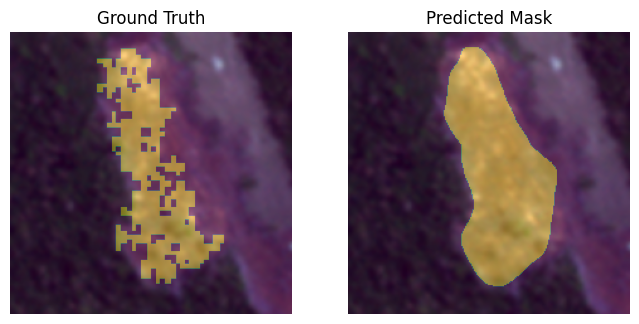

In [16]:
batch_sample, batch_mask = next(loader)
batch_sample, batch_mask = batch_sample.to(device), batch_mask.to(device)
batch_output = model(batch_sample)
batch_predictions = batch_output.argmax(dim=1)
visualise_batch_predictions(batch_sample[0:1], batch_mask.unsqueeze(1)[0:1], batch_predictions.unsqueeze(1)[0:1], rescale=True, bands=bands)
